# Environment setup

This notebook  with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [5]:
import planetary_computer

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# planetary_computer.settings.set_subscription_key("add your key here")

# Open and explore the 3dep-seamless collection

[3DEP](https://www.usgs.gov/core-science-systems/ngp/3dep) is a national elevation dataset program from the USGS.
It provides elevation data for the entire United States using a wide variety of survey methods, including modern lidar airborne surveys.
The Planetary Computer hosts seamless elevation Digital Elevation Models (DEMs) at two resolutions, 1/3 arc-second and 1 arc-second.

In [6]:
from pystac_client import Client

catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
threedep = catalog.get_child(id="3dep-seamless")

The 3DEP seamless dataset covers the entire United States, as you can see from the bounds:

In [7]:
threedep.extent.spatial.to_dict()

{'bbox': [[-174.001666666983,
   -15.00166666667,
   164.0016666666,
   84.00166666666]]}

# Plotting elevation data

Let's take a look at Mt. Shasta in Northern California.
We define a point, then find a bounding box around that point.
The query area for this example is pretty small, and we will only fetch one tile -- you can increase the buffer size and this example should work with multiple tiles (though the plotting will take longer).

In [8]:
latitude = 41.41505315463394
longitude = -122.19468933831948
buffer = 0.1
bbox = [
    longitude - buffer,
    latitude - buffer,
    longitude + buffer,
    latitude + buffer
]
search = catalog.search(collections="3dep-seamless", bbox=bbox)
items = list(search.items())
print(f"{len(items)} items found")

2 items found


The Planetary Computer hosts both the 1 arc-second (nominal 30m pixel size) and 1/3 arc-second (nominal 10m pixel size) resolution 3DEP data.
Let's seperate the two sets into their own lists by filtering on the Ground Sample Distance (GSD) in the STAC items:

In [9]:
items_low_res = [item for item in items if item.properties["gsd"] == 30]
items_high_res = [item for item in items if item.properties["gsd"] == 10]
assert len(items_high_res) == len(items_low_res)
assert len(items_low_res) == len(items) / 2

DEMs are relatively simple raster datsets -- they only have one band (elevation).
Let's compare visualization high and low resolution images, for our area of interest.
The assets are not publicly available without a Planetary Computer API key, so you'll need to sign the asset hrefs in order to access them.

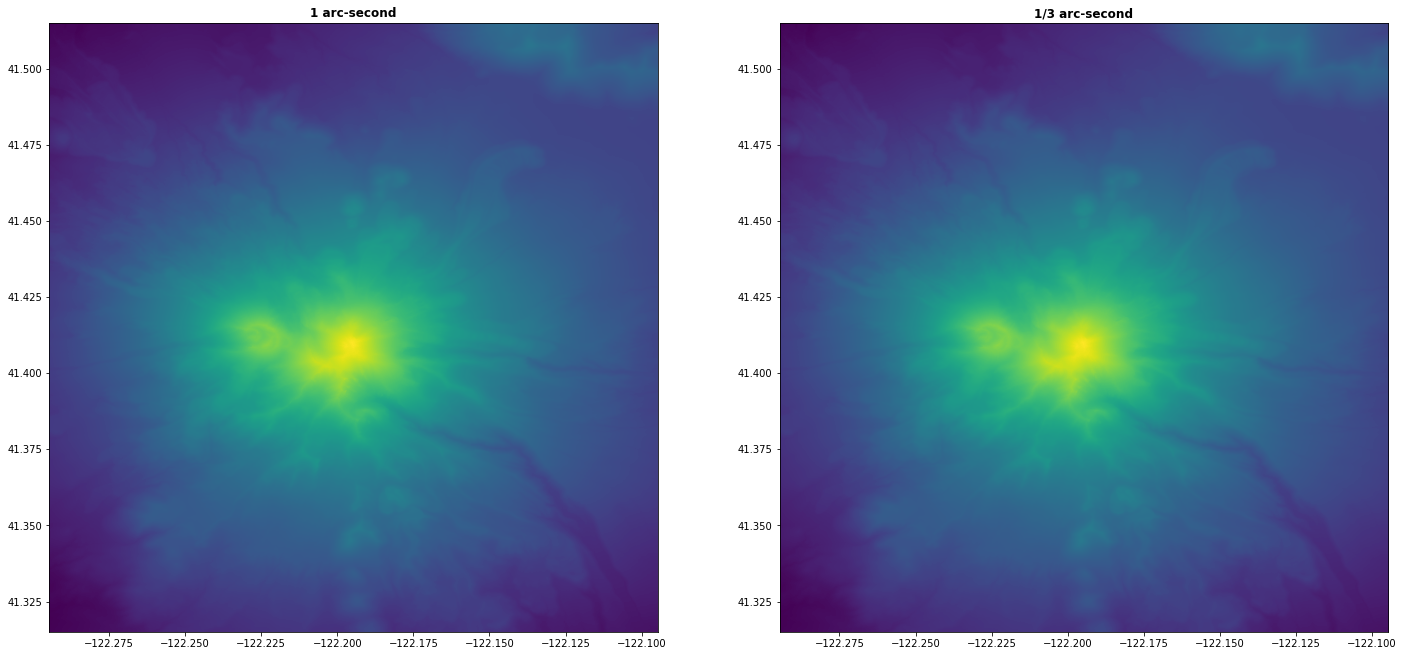

In [10]:
import rasterio.merge
from rasterio.plot import show
import numpy
from matplotlib import pyplot

def merge_asset_data(items):
    asset_hrefs = [planetary_computer.sign(item.assets["data"].href) for item in items]
    data, transform = rasterio.merge.merge(datasets=asset_hrefs, bounds=bbox)
    return numpy.squeeze(data), transform

low_res_data, low_res_transform = merge_asset_data(items_low_res)
high_res_data, high_res_transform = merge_asset_data(items_high_res)

figure, (axes_low_res, axes_high_res) = pyplot.subplots(1, 2, figsize=(24, 12))
show(low_res_data, transform=low_res_transform, ax=axes_low_res, title="1 arc-second")
show(high_res_data, transform=high_res_transform, ax=axes_high_res, title="1/3 arc-second")
pyplot.show()